In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load the necessary functions

In [2]:
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/snn_utils.py .
import snn_utils
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/utils.py .
import utils
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/loss.py .
import loss
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/fully_connected/decolle_model.py .
import decolle_model
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/fully_connected/spike_functions.py .
import spike_functions
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/fully_connected/neuron_models.py .
import neuron_models
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/fully_connected/analog_synapses.py .
import analog_synapses
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/fully_connected/non_linear_decolle_model.py .
import non_linear_decolle_model

load the spike dataset

In [3]:
import torch
device = torch.device('cuda') #cpu/ cuda (available one)

gen_train = snn_utils.get_mnist_loader(100, Nparts=1, train=True)
gen_test = snn_utils.get_mnist_loader(100, Nparts=1, train=False)

T = 100 #duration of sequence
data, target = next(loss.iter_mnist(gen_train, T=T))

net = non_linear_decolle_model.LenetDECOLLE(input_shape = data.shape[2:], mlp_neurons = [150,120], num_conv_layers=0, num_mlp_layers=2, alpha=[.95],beta=[.92] ,lc_ampl=.5, out_channels=10).to(device)

data_d = data.to(device)
print(data_d.transpose(0,1).shape)
target_d = target.to(device)
net.init_parameters(data_d.transpose(0,1))

100%|██████████| 9912422/9912422 [00:00<00:00, 76695077.48it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28053657.67it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33803993.38it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22706232.14it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



torch.Size([60, 100, 1, 28, 28])


this is a trained network for demonstration

In [ ]:
#Run only if you are loading a previously trained model in
PATH = '/content/drive/MyDrive/MNIST_SNN_FG/mnist_network_fg_nn.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

train the network

In [ ]:
opt = torch.optim.Adamax(net.get_trainable_parameters(), lr=1e-4, betas=[0., .95]) # lr=0.0001/0.001 #will try changing learning rate after few epochs

for e in range(30):
    accuracy=[]
    error = []
    for data, label in loss.iter_mnist(gen_train, T=T):
        net.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=10)
        readout = 0
        for n in range(T):
            st, rt, ut = net.forward(data_d[n])
            loss_tv = loss.decolle_loss(rt, label_d[n])
            loss_tv.backward()
            opt.step()
            opt.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]
        error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
        accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)
    print('Epoch', e, 'Loss', loss_hist.data)
    #PATH = '/YOUR/DESIRED/PATH.pth'
    #torch.save(net.state_dict(), PATH)

Training Error tensor(0.8667)
Training accuracy tensor(0.1333)
Epoch 0 Loss tensor(10.6386, device='cuda:0')
Training Error tensor(0.8667)
Training accuracy tensor(0.1333)
Epoch 1 Loss tensor(10.3565, device='cuda:0')
Training Error tensor(0.8500)
Training accuracy tensor(0.1500)
Epoch 2 Loss tensor(10.1886, device='cuda:0')
Training Error tensor(0.8667)
Training accuracy tensor(0.1333)
Epoch 3 Loss tensor(10.0672, device='cuda:0')
Training Error tensor(0.8167)
Training accuracy tensor(0.1833)
Epoch 4 Loss tensor(9.9904, device='cuda:0')
Training Error tensor(0.7333)
Training accuracy tensor(0.2667)
Epoch 5 Loss tensor(9.9216, device='cuda:0')
Training Error tensor(0.6833)
Training accuracy tensor(0.3167)
Epoch 6 Loss tensor(9.8495, device='cuda:0')
Training Error tensor(0.6667)
Training accuracy tensor(0.3333)
Epoch 7 Loss tensor(9.8207, device='cuda:0')
Training Error tensor(0.6000)
Training accuracy tensor(0.4000)
Epoch 8 Loss tensor(9.7822, device='cuda:0')
Training Error tensor(0.

test the network

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#from resources.plotcm import plot_confusion_matrix

error = []
accuracy=[]
y_pred = []
y_true = []


for data, label in loss.iter_mnist(gen_test, T=T):
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=100)
        readout = 0
        with torch.no_grad():
          for n in range(T):
             st, rt, ut=net.forward(data_d[n])
             loss_tv = loss.decolle_loss(rt, label_d[n])

             loss_hist += loss_tv
             readout += rt[-1]
          output = (readout.argmax(axis=1)).data.cpu().numpy()
          y_pred.extend(output)
          labels =(label_d[-1].argmax(axis=1)).data.cpu().numpy()
          y_true.extend(labels)
          accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
          error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)
accuracy=torch.mean(torch.Tensor(accuracy)).item()
# Build confusion matrix
classes = ('O', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)



cm

Testing Error tensor(0.4000)
Testing accuracy tensor(0.6000)


array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 2]])

confusion matrix

<ipython-input-10-4b0e1475a74f>:6: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


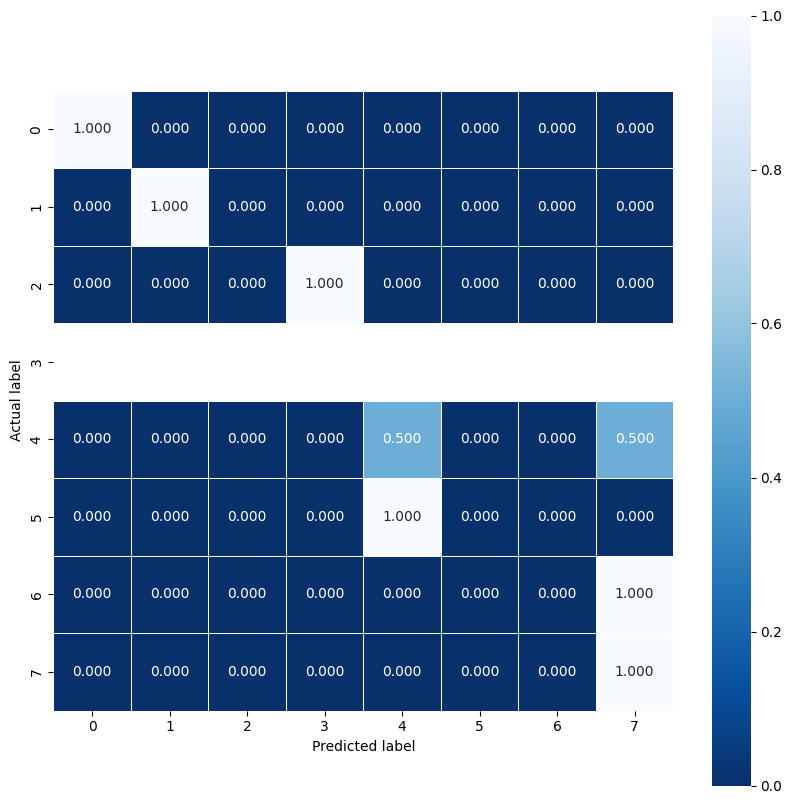

In [ ]:
# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
cm = metrics.confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#plt.savefig('/YOUR/DESIRED/PATH.svg')